In [0]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [0]:
env = gym.make('CartPole-v0')
env.seed(1234)
np.random.seed(1234)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

In [0]:
class QNetwork(nn.Module):
    def __init__(self, gamma=0.99, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, batch_size=20,
                 name='QNetwork'):
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [0]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

In [0]:
train_episodes = 300          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 200               # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [0]:
mainQN = QNetwork(name='main', hidden_size=hidden_size, gamma=gamma, learning_rate=learning_rate,batch_size=batch_size).to('cuda')

In [0]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        state = next_state

In [70]:
# Now train with experiences
#saver = tf.train.Saver()
rewards_list = []
step = 0
opt = optim.Adam(mainQN.parameters(), learning_rate)

for ep in range(1, train_episodes):
    total_reward = 0
    t = 0
    while t < max_steps:
        step += 1

        # Uncomment this next line to watch the training
        # env.render() 

        # Explore or Exploit
        explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
        if explore_p > np.random.rand():
            # Make a random action
            action = env.action_space.sample()
        else:
            # Get action from Q-network
            Qs = mainQN(Variable(torch.cuda.FloatTensor(state), volatile=True)).cpu().data.numpy()
            action = np.argmax(Qs)

        # Take action, get new state and reward
        next_state, reward, done, _ = env.step(action)

        total_reward += reward

        if done:
            # the episode ends so no next state
            # next_state = np.zeros(state.shape)
            t = max_steps

            print('Episode: {}'.format(ep),
                  'Total reward: {}'.format(total_reward),
                  'Training loss: {:.4f}'.format(loss.cpu().data.numpy()),
                  'Explore P: {:.4f}'.format(explore_p))
            rewards_list.append((ep, total_reward))

            # Add experience to memory
            memory.add((state, action, reward, next_state, done))

            # Start new episode
            env.reset()
            # Take one random step to get the pole and cart moving
            state, reward, done, _ = env.step(env.action_space.sample())

        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state, done))
            state = next_state
            t += 1

        # Sample mini-batch from memory
        batch = memory.sample(batch_size)
        states = np.array([each[0] for each in batch])
        ### ポイント！！！
        # actionはスカラーなのでベクトルにする
        # actionsはベクトルでなく、statesと同じ行列
        actions = np.array([[each[1]] for each in batch])
        ### ポイント終わり
        rewards = np.array([each[2] for each in batch])
        next_states = np.array([each[3] for each in batch])
        dones = np.array([each[4] for each in batch])
        
        # Train network
        non_final_mask = torch.tensor(tuple(map(lambda s: s==False, dones)), dtype=torch.uint8).to('cuda')
        # 終端状態のQ値はその後の報酬が存在しないためゼロとする
        target_maxQs = torch.zeros(batch_size).to('cuda')
        target_maxQs[non_final_mask] = mainQN(Variable(torch.cuda.FloatTensor(next_states)[non_final_mask])).max(1)[0].detach()

        #tutorial way
        targets = (torch.cuda.FloatTensor(rewards) + gamma * target_maxQs).unsqueeze(1)
        current_q_values = mainQN(Variable(torch.cuda.FloatTensor(states))).gather(1, torch.cuda.LongTensor(actions))
        
        loss = torch.nn.MSELoss()(current_q_values, targets)
        # backpropagation of loss to NN
        # 勾配を初期化
        opt.zero_grad()
        loss.backward()
        opt.step()

Episode: 1 Total reward: 18.0 Training loss: 1.0220 Explore P: 0.9982
Episode: 2 Total reward: 15.0 Training loss: 1.0445 Explore P: 0.9967
Episode: 3 Total reward: 16.0 Training loss: 1.2438 Explore P: 0.9952
Episode: 4 Total reward: 11.0 Training loss: 1.7662 Explore P: 0.9941
Episode: 5 Total reward: 16.0 Training loss: 3.4938 Explore P: 0.9925


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Episode: 6 Total reward: 18.0 Training loss: 9.8963 Explore P: 0.9907
Episode: 7 Total reward: 49.0 Training loss: 54.8644 Explore P: 0.9859
Episode: 8 Total reward: 14.0 Training loss: 130.4146 Explore P: 0.9846
Episode: 9 Total reward: 17.0 Training loss: 180.7490 Explore P: 0.9829
Episode: 10 Total reward: 17.0 Training loss: 374.7872 Explore P: 0.9813
Episode: 11 Total reward: 14.0 Training loss: 327.8758 Explore P: 0.9799
Episode: 12 Total reward: 10.0 Training loss: 229.0101 Explore P: 0.9789
Episode: 13 Total reward: 44.0 Training loss: 312.1285 Explore P: 0.9747
Episode: 14 Total reward: 16.0 Training loss: 361.3842 Explore P: 0.9731
Episode: 15 Total reward: 10.0 Training loss: 209.9120 Explore P: 0.9722
Episode: 16 Total reward: 11.0 Training loss: 136.3945 Explore P: 0.9711
Episode: 17 Total reward: 33.0 Training loss: 74.0025 Explore P: 0.9680
Episode: 18 Total reward: 28.0 Training loss: 79.6190 Explore P: 0.9653
Episode: 19 Total reward: 16.0 Training loss: 69.4573 Explor

Text(0, 0.5, 'Total Reward')

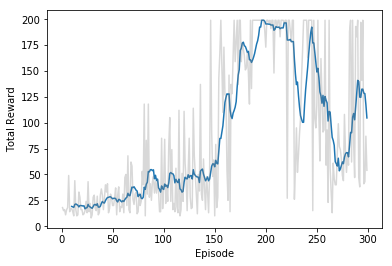

In [71]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')